In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Run Segment Anything Model 2 on a live video stream


In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from IPython import display

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 camera predictor


In [4]:
from sam2.build_sam import build_sam2_camera_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_camera_predictor(model_cfg, sam2_checkpoint)

In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_bbox(bbox, ax, marker_size=200):
    tl, br = bbox[0], bbox[1]
    w, h = (br - tl)[0], (br - tl)[1]
    x, y = tl[0], tl[1]
    print(x, y, w, h)
    ax.add_patch(plt.Rectangle((x, y), w, h, fill=None, edgecolor="blue", linewidth=2))

#### Select an video stream (video or camera)


In [6]:
def images_to_video(image_folder, output_video_path='tmp.mp4', fps=30):
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])
    
    if not image_files:
        print("No images found in folder.")
        return
    
    # ask if removing existing video
    if os.path.exists(output_video_path):
        remove_existing = input(f"Video {output_video_path} already exists. Do you want to remove it? (y/n): ")
        if remove_existing.lower() == 'y':
            os.remove(output_video_path)
        else:
            print("Video not created.")
            return


    first_image_path = os.path.join(image_folder, image_files[0])
    first_image = cv2.imread(first_image_path)
    height, width, layers = first_image.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Failed to load image {image_file}")
            continue

        video_writer.write(image)
    
    video_writer.release()
    print(f"Video saved at {output_video_path}")

In [8]:
# cap = cv2.VideoCapture("videos/aquarium.mp4")
# img_folder = "/home/steven_kuang/Documents/dataset/phantom/dense/cactussed"
img_folder = "/home/steven_kuang/Documents/dataset/phantom/stable/2D_imgs"
images_to_video(img_folder)
cap = cv2.VideoCapture("tmp.mp4")
os.remove("tmp.mp4")

# cap = cv2.VideoCapture(2)
# check if the camera is opened
if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()
ret, frame = cap.read()
width, height = frame.shape[:2][::-1]

Video saved at tmp.mp4


#### Step 1: Add a first click on the first frame


Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
549.0 498.0 201.0 206.0


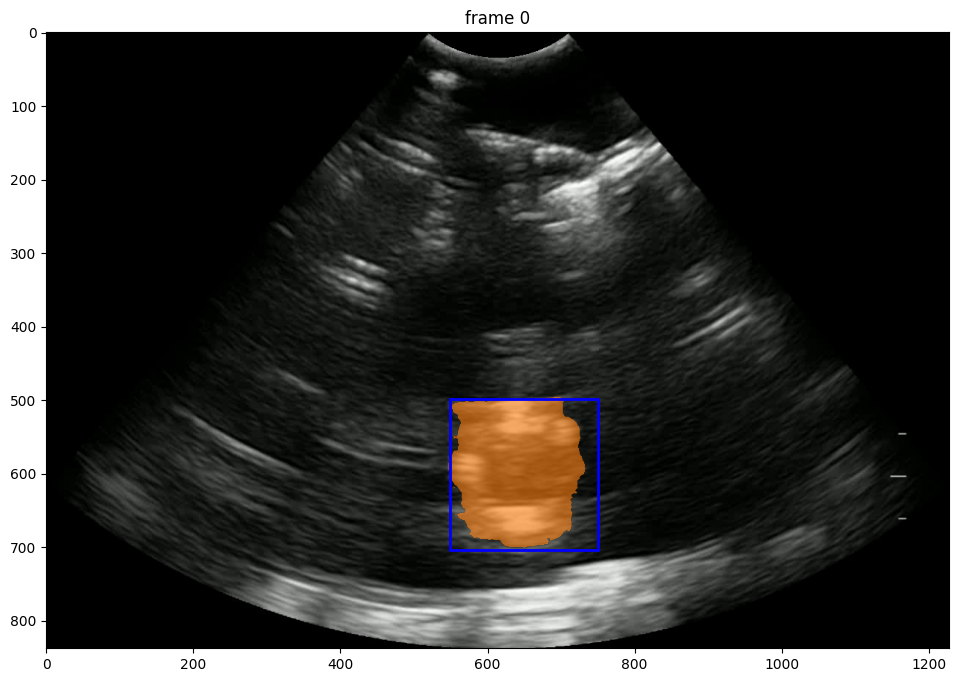

In [9]:
# predictor.reset_state(inference_state)
predictor.load_first_frame(frame)
if_init = True

using_point = False # if True, we use point prompt
using_box = True # if True, we use point prompt
using_mask= False  # if True, we use mask prompt

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = (
    1  # give a unique id to each object we interact with (it can be any integers)
)
# Let's add a positive click at (x, y) = (210, 350) to get started

# using point prompt
points = np.array([[670, 247]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], dtype=np.int32)


if using_box:
    # bbox = np.array([[600, 214], [765, 286]], dtype=np.float32)
    roi = cv2.selectROI("Select the box", frame)
    cv2.destroyAllWindows()
    bbox = np.array([[roi[0], roi[1]], [roi[0] + roi[2], roi[1] + roi[3]]], dtype=np.float32)

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(frame)


if using_point:
    _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )
    show_points(points, labels, plt.gca())

elif using_box:
    _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
        frame_idx=ann_frame_idx, obj_id=ann_obj_id, bbox=bbox
    )
    show_bbox(bbox, plt.gca())

elif using_mask:
    mask_img_path="masks/aquarium/aquarium_mask.png"
    mask = cv2.imread(mask_img_path, cv2.IMREAD_GRAYSCALE)
    mask = mask / 255

    _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
        frame_idx=ann_frame_idx, obj_id=ann_obj_id, mask=mask
    )
    


show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#### Step 2: track


KeyboardInterrupt: 

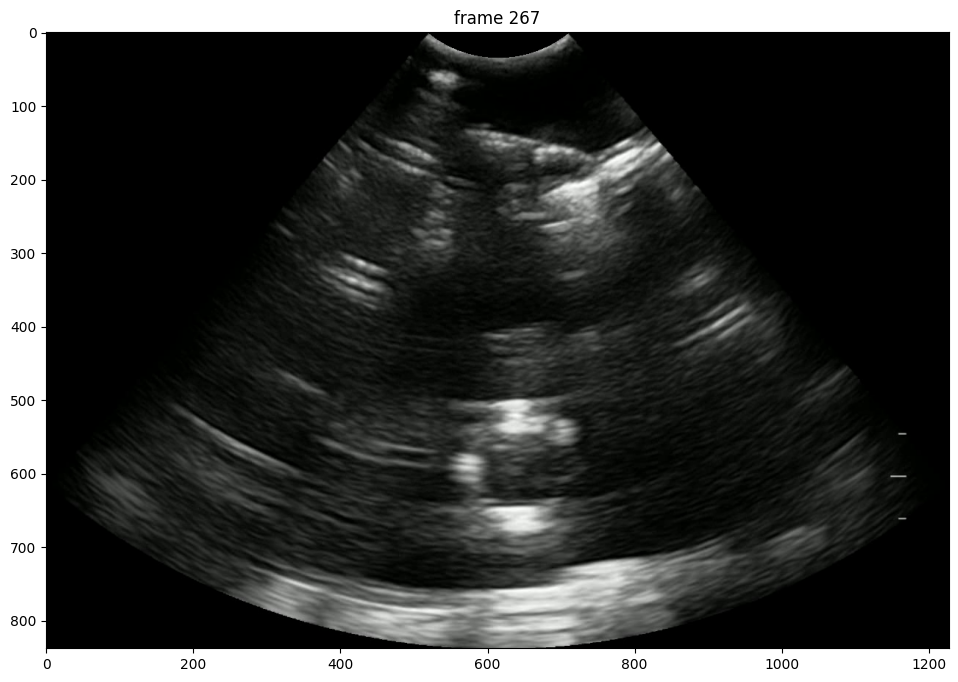

In [10]:
vis_gap = 1

SAVE = False
if SAVE:
    vis_gap = 1
    if img_folder is not None:
        save_folder = img_folder.replace("cactussed", "sam2_output")
        os.makedirs(save_folder, exist_ok=True)
    else:
        save_folder = "sam2_output"
        os.makedirs(save_folder, exist_ok=True)
    print(f"Saving images to {save_folder}")

while True:

    ret, frame = cap.read()
    ann_frame_idx += 1
    if not ret:
        break
    width, height = frame.shape[:2][::-1]

    out_obj_ids, out_mask_logits = predictor.track(frame)
    h, w = None, None
    if ann_frame_idx % vis_gap == 0:
        if not SAVE:
            print(f"frame {ann_frame_idx}")
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            display.clear_output(wait=True)
            plt.figure(figsize=(12, 8))
            plt.title(f"frame {ann_frame_idx}")
            plt.imshow(frame)
            show_mask(
                (out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0]
            )
            plt.show()
        else:
            # save only the mask
            mask = (out_mask_logits[0] > 0.0).cpu().numpy()
            if h is None:
                h, w = mask.shape[-2:]
            mask = mask.reshape(h, w)
            mask = mask.astype(np.uint8) * 255
            Image.fromarray(mask).save(os.path.join(save_folder, f"{ann_frame_idx:05d}.png"))


cap.release()